In [58]:
import TP_4_modulos
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def create_set(size = 10000):

    X, Y = TP_4_modulos.generate_dna_sequences(size)
    X = np.array([np.array(TP_4_modulos.one_hot_encoding(x)).flatten() for x in X])
    Y = torch.tensor(Y, dtype = torch.float32).reshape(-1, 1)
    X = torch.tensor(X)

    return X, Y

X, Y = create_set(5000)
X_test, Y_test = create_set(1000)

dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

dataset_val = TensorDataset(X_test, Y_test)
dataloader_val = DataLoader(dataset_val, batch_size = 10, shuffle = False)

In [3]:
my_nn = nn.Sequential(
    nn.Linear(4000, 3),
    nn.ReLU(),
    nn.Linear(3, 3),
    nn.ReLU(),
    nn.Linear(3, 1),
    nn.Sigmoid())

LF = nn.BCELoss()

optimizer = optim.SGD(my_nn.parameters(), lr=1e-3, weight_decay = 1e-4)

In [4]:
def train(network, optimizer, 
          criterion, 
          train_loader = None):
    
    network.train()
    batch_size = train_loader.batch_size
    total_loss = 0

    for batch_i, (data, target) in enumerate(train_loader):

        
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
            
        
    avg_loss = total_loss / len(train_loader)
    return avg_loss


def test(network, criterion, valid_loader):
    
    network.eval()
    total_val_loss = 0
    batch_size = valid_loader.batch_size
    
    with torch.inference_mode():
        for batch_i, (data, target) in enumerate(valid_loader):
            output = network(data)
            val_loss = criterion(output, target)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(valid_loader)
    return avg_val_loss

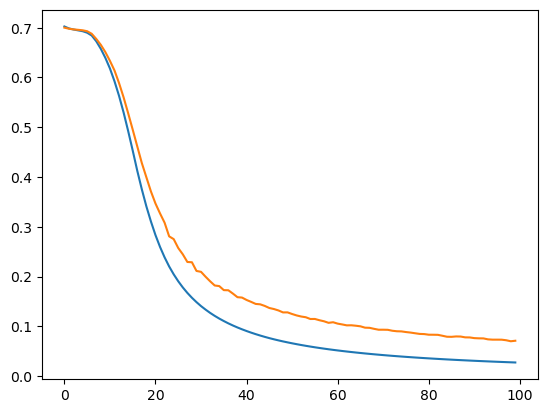

In [5]:
losses = []
losses_val = []
for epoch in range(100):
        
    avg_train_loss = train(my_nn, optimizer, LF, dataloader)
    avg_val_loss = test(my_nn, LF, dataloader_val)
    losses.append(avg_train_loss)
    losses_val.append(avg_val_loss)

plt.plot(losses)
plt.plot(losses_val)
plt.show()

In [6]:
Y_hat = my_nn(X_test)

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(Y_test.detach(), Y_hat.detach())

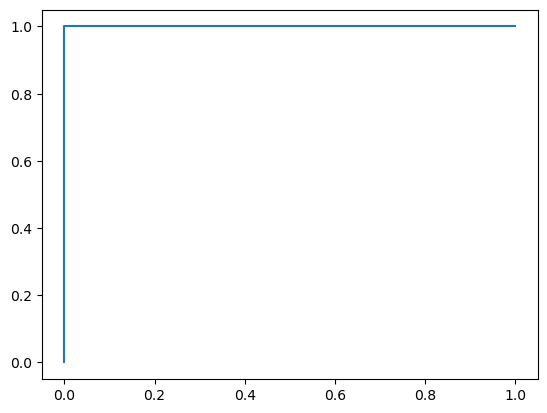

1.0


In [8]:
plt.plot(fpr, tpr)
plt.show()
print(roc_auc_score(Y_test.detach(), Y_hat.detach()))

In [84]:
promotores = TP_4_modulos.read_fasta_as_list('promotores.fasta')
promptores_one_hot = np.array([np.array(TP_4_modulos.one_hot_encoding(x)) for x in promotores])
random_seqs = np.array([TP_4_modulos.dinucleotide_shuffle(x).flatten() for x in promptores_one_hot])
X = np.array([x.flatten() for x in promptores_one_hot])
X_neg = np.array([x.flatten() for x in random_seqs])
X = np.vstack([X, X_neg])
Y = np.array([1 for _ in range(1870)] + [0 for _ in range(1870)])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15)

y_train = torch.tensor(y_train, dtype = torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype = torch.float32).reshape(-1, 1)
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

dataset = TensorDataset(X_train, y_train)
dataset_val = TensorDataset(X_test, y_test) 
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=10, shuffle=False)

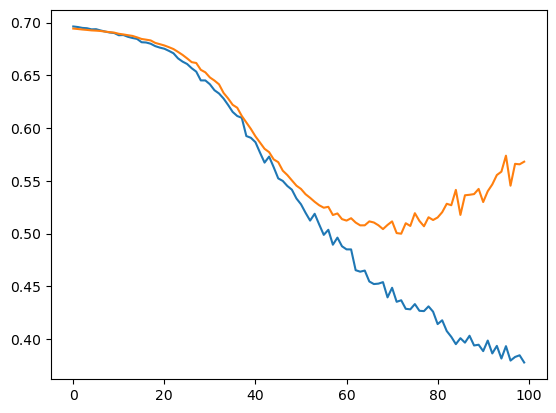

In [89]:
my_nn = nn.Sequential(
    nn.Linear(2400, 3),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(3, 5),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(5, 1),
    nn.Sigmoid())

LF = nn.BCELoss()

optimizer = optim.SGD(my_nn.parameters(), lr=1e-3, weight_decay = 1e-3)

losses = []
losses_val = []
for epoch in range(100):
        
    avg_train_loss = train(my_nn, optimizer, LF, dataloader)
    avg_val_loss = test(my_nn, LF, dataloader_val)
    losses.append(avg_train_loss)
    losses_val.append(avg_val_loss)

plt.plot(losses)
plt.plot(losses_val)
plt.show()

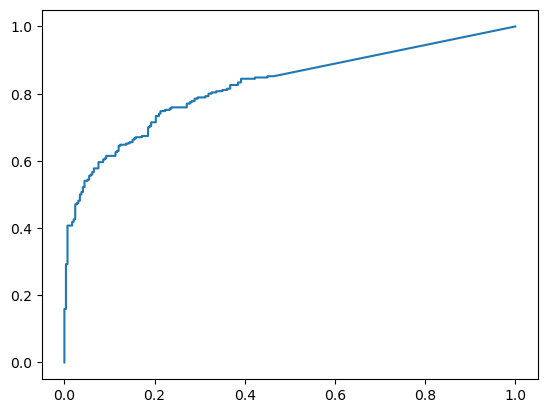

0.8245004454626448


In [90]:
Y_hat = my_nn(X_test)
fpr, tpr, thresholds = roc_curve(y_test.detach(), Y_hat.detach())
plt.plot(fpr, tpr)
plt.show()
print(roc_auc_score(y_test.detach(), Y_hat.detach()))